Import Dependencies

In [ ]:
from pydantic import BaseModel, Field

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.messages import convert_to_openai_messages, convert_to_messages

from jinja2 import Template
from typing import Literal, Dict, Any, Annotated, List
from IPython.display import Image, display
from operator import add
from openai import OpenAI

import random
import ast
import inspect
import instructor
import json

from utils.utils import  format_ai_message, get_tool_descriptions





<h4>Single Node Graph</h4>

In [14]:
class State(BaseModel):
    message:str
    answer: str = ""
    vibe: str

In [15]:
def append_vibes_to_query(state: State) -> dict:

    return {
        "answer": f"{state.message} {state.vibe}"
    }


In [16]:
workflow = StateGraph(State)

workflow.add_node("append_vibes_to_query", append_vibes_to_query)

workflow.add_edge(START, "append_vibes_to_query")
workflow.add_edge("append_vibes_to_query", END)

graph = workflow.compile()

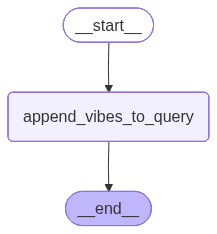

In [17]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
initial_state = {
    "message": "give me some vibes",
    "vibe": "I'm feeling like a badass today!"
}

In [19]:
result = graph.invoke(initial_state)

In [20]:
result

{'message': 'give me some vibes',
 'answer': "give me some vibes I'm feeling like a badass today!",
 'vibe': "I'm feeling like a badass today!"}

In [21]:
initial_state = {
    "message": "give me some vibes",
    "answer": "abs",
    "vibe": "I'm feeling like a badass today!"
}

In [22]:
result = graph.invoke(initial_state)

In [23]:
result

{'message': 'give me some vibes',
 'answer': "give me some vibes I'm feeling like a badass today!",
 'vibe': "I'm feeling like a badass today!"}

<h4> Conditional Graph </h4>

In [30]:
class State(BaseModel):
    message: str
    answer: str = ""

In [40]:
def append_vibes_to_query(state: State) -> dict:

    return {
        "answer": state.message
    }

In [41]:
def router(state:State)->Literal["append_vibe_1", "append_vibe_2", "append_vibe3"]:

    vibes = ["append_vibe_1", "append_vibe_2", "append_vibe3"]

    vibe_path = random.choice(vibes)
    return vibe_path


In [42]:
def append_vibe_1(state:State) -> dict:
    vibe = "I'm feeling like a badass today!"

    return {
        "answer": f"{state.answer} {vibe}"
    }

def append_vibe_2(state:State) -> dict:
    vibe = "I'm feeling like a boss today!"

    return {
        "answer": f"{state.answer} {vibe}"
    }

def append_vibe_3(state:State) -> dict:
    vibe = "I'm feeling like a legend today!"

    return {
        "answer": f"{state.answer} {vibe}"
    }



In [43]:
workflow = StateGraph(State)

workflow.add_node("append_vibes_to_query", append_vibes_to_query)
workflow.add_node("append_vibe_1", append_vibe_1)
workflow.add_node("append_vibe_2", append_vibe_2)
workflow.add_node("append_vibe_3", append_vibe_3)

workflow.add_conditional_edges(
    "append_vibes_to_query",
    router, 
    {
        "append_vibe_1": "append_vibe_1",
        "append_vibe_2": "append_vibe_2",
        "append_vibe_3": "append_vibe_3",
    }
    
)

workflow.add_edge(START, "append_vibes_to_query")
workflow.add_edge("append_vibe_1", END)
workflow.add_edge("append_vibe_2", END)
workflow.add_edge("append_vibe_3", END)


graph = workflow.compile()

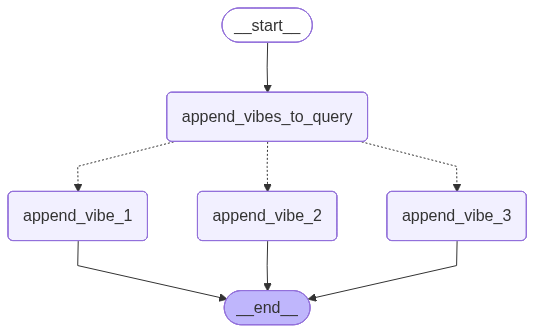

In [44]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [47]:
initial_state = {
    "message": "I am here to add  some vibes",
}

In [48]:
result = graph.invoke(initial_state)

In [49]:
result

{'message': 'I am here to add  some vibes',
 'answer': "I am here to add  some vibes I'm feeling like a boss today!"}

In [52]:
result = graph.invoke(initial_state)

In [53]:
result

{'message': 'I am here to add  some vibes',
 'answer': "I am here to add  some vibes I'm feeling like a badass today!"}

<h4>Agent Graph</h4>

In [4]:
def append_vibes(query:str, vibe:str) -> str:
    """Takes in a query and a vibe and returns a string with the query and the vibe apended
    
    Args:
        query: The query to append the vibe to.
        vibe: The vibe to append to the query.

    Returns:
        A string with the query and vibe appended
    """
    return f"{query} {vibe}" 

In [5]:
get_tool_descriptions([append_vibes])

[{'name': 'append_vibes',
  'description': 'Takes in a query and a vibe and returns a string with the query and the vibe apended',
  'parameters': {'type': 'object',
   'properties': {'query': {'type': 'string',
     'description': 'The query to append the vibe to.'},
    'vibe': {'type': 'string',
     'description': 'The vibe to append to the query.'}}},
  'required': ['query', 'vibe'],
  'returns': {'type': 'string',
   'description': 'A string with the query and vibe appended'}}]

In [9]:
class ToolCall(BaseModel):
    name: str
    arguments: dict

class AgentResponse(BaseModel):
    answer: str
    tool_calls: List[ToolCall] = Field(default_factory=list)


class State(BaseModel):
    messages: Annotated[List[Any], add] = []
    message: str = ""
    iteration: int = 0
    answer: str = ""
    available_tools: List[Dict[str, Any]] = []
    tool_calls: List[ToolCall] = []

In [18]:
def agent_node(state:State) -> dict:
    prompt_template = """"
    You are an assistant that is generating vibes for a user.
    
    You will be given a selection of tools you can use to add vibes to a user's query.

    <Available tools>
    {{available_tools | tojson}}
    </Available tools>

    When you need to use a tool, format the response as:

    <tool_call>
    {"name": "tool_name", "arguments": {...}}
    </tool call>

    Instructions:
    -You need to use the tools to add vibes to the user's query.
    -Add a random vibe to the user's query
     """
    
    template = Template(prompt_template)

    prompt = template.render(
        available_tools = state.available_tools
    )

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model ="gpt-4.1-mini",
        response_model = AgentResponse,
        messages= [{"role": "system", "content": prompt}, {"role": "user", "content": state.message}],
        temperature =0.5,
    )

    ai_message = format_ai_message(response)

    return {
        "messages": [ai_message],
        "tool_calls": response.tool_calls
    }



<h5>Small tutorial- messages formatting</h5>

In [10]:
conversation = [
    {'role': "user", 'content': "give me some vibes"},
    {'role': "assistant", 'content': "I am here to add some vibes"},
    {'role': "user", 'content': "I am feeling well today"},
]

In [11]:
convert_to_messages(conversation)

[HumanMessage(content='give me some vibes', additional_kwargs={}, response_metadata={}),
 AIMessage(content='I am here to add some vibes', additional_kwargs={}, response_metadata={}, tool_calls=[], invalid_tool_calls=[]),
 HumanMessage(content='I am feeling well today', additional_kwargs={}, response_metadata={})]

In [12]:
convert_to_openai_messages(convert_to_messages(conversation))

[{'role': 'user', 'content': 'give me some vibes'},
 {'role': 'assistant', 'content': 'I am here to add some vibes'},
 {'role': 'user', 'content': 'I am feeling well today'}]

In [14]:
dummy_response = AgentResponse(
    answer="I am here to add some vibes",
    tool_calls=
    [ToolCall(name="append_vibes", arguments={"query":"Give me some vibes", "vibe": "I am feeling very well today"})])

In [15]:
dummy_response

AgentResponse(answer='I am here to add some vibes', tool_calls=[ToolCall(name='append_vibes', arguments={'query': 'Give me some vibes', 'vibe': 'I am feeling very well today'})])

<h5> End of Small tutorial- messages formatting</h5>

In [16]:
def tool_router(state: State) ->str:
#Decide whether to continue or end"""
    if len(state.tool_calls) > 0:
        return "tools"
    else:
        return "end"
        

In [19]:
workflow = StateGraph(State)

tools = [append_vibes]
tool_node = ToolNode(tools)
tool_descriptions = get_tool_descriptions(tools)


workflow.add_node("agent_node", agent_node)
workflow.add_node("tool_node", tool_node)

workflow.add_edge(START, "agent_node")


workflow.add_conditional_edges(
    "agent_node",
    tool_router, 
    {
        "tools": "tool_node",
        "end": END
    }
    
)

workflow.add_edge("tool_node", END)



graph = workflow.compile()

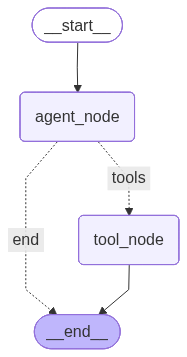

In [20]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
initial_state = {
    "message": "Give me some vibes",
    "available_tools": tool_descriptions
}
result = graph.invoke(initial_state)

In [22]:
result

{'messages': [AIMessage(content='Adding some vibes to your request!', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'append_vibes', 'args': {'query': 'Give me some vibes', 'vibe': 'chill and positive vibes'}, 'id': 'call_0', 'type': 'tool_call'}], invalid_tool_calls=[]),
  ToolMessage(content='Give me some vibes chill and positive vibes', name='append_vibes', tool_call_id='call_0')],
 'message': 'Give me some vibes',
 'available_tools': [{'name': 'append_vibes',
   'description': 'Takes in a query and a vibe and returns a string with the query and the vibe apended',
   'parameters': {'type': 'object',
    'properties': {'query': {'type': 'string',
      'description': 'The query to append the vibe to.'},
     'vibe': {'type': 'string',
      'description': 'The vibe to append to the query.'}}},
   'required': ['query', 'vibe'],
   'returns': {'type': 'string',
    'description': 'A string with the query and vibe appended'}}],
 'tool_calls': [ToolCall(name='append_vib

<h4> Agent Graph With Loopback from Tools(ReAct Agent) </h4>

In [49]:
def append_vibes(query:str, vibe:str) -> str:
    """Takes in a query and a vibe and returns a string with the query and the vibe apended
    
    Args:
        query: The query to append the vibe to.
        vibe: The vibe to append to the query.

    Returns:
        A string with the query and vibe appended
    """
    return f"{query} {vibe}" 

In [50]:
class ToolCall(BaseModel):
    name: str
    arguments: dict

class AgentResponse(BaseModel):
    answer: str
    tool_calls: List[ToolCall] = Field(default_factory=list)


class State(BaseModel):
    messages: Annotated[List[Any], add] = []
    message: str = ""
    iteration: int = 0
    answer: str = ""
    available_tools: List[Dict[str, Any]] = []
    tool_calls: List[ToolCall] = []

In [51]:
def agent_node(state:State) -> dict:
    prompt_template = """"
    You are an assistant that is generating vibes for a user.
    
    You will be given a selection of tools you can use to add vibes to a user's query.

    <Available tools>
    {{available_tools | tojson}}
    </Available tools>

    When you need to use a tool, format the response as:

    <tool_call>
    {"name": "tool_name", "arguments": {...}}
    </tool call>

    Instructions:
    -You need to use the tools to add vibes to the user's query.
    -Add a random vibe to the user's query.
    -You must return a tool call in the first interaction.
     """
    
    template = Template(prompt_template)

    prompt = template.render(
        available_tools = state.available_tools
    )
    messages = state.messages
    conversation = convert_to_openai_messages(messages)

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model ="gpt-4.1-mini",
        response_model = AgentResponse,
        messages= [{"role": "system", "content": prompt}, *conversation],
        temperature =0.5,
    )

    ai_message = format_ai_message(response)

    return {
        "messages": [ai_message],
        "tool_calls": response.tool_calls,
        "iteration": state.iteration +1,
        "answer": response.answer
    }



In [52]:
def tool_router(state: State) ->str:
#Decide whether to continue or end"""
    if state.iteration > 1:
        return "end"
    elif len(state.tool_calls) > 0:
            return "tools"
    else:
        return "end"

In [53]:
workflow = StateGraph(State)

tools = [append_vibes]
tool_node = ToolNode(tools)
tool_descriptions = get_tool_descriptions(tools)


workflow.add_node("agent_node", agent_node)
workflow.add_node("tool_node", tool_node)

workflow.add_edge(START, "agent_node")


workflow.add_conditional_edges(
    "agent_node",
    tool_router, 
    {
        "tools": "tool_node",
        "end": END
    }
    
)

workflow.add_edge("tool_node", "agent_node")




graph = workflow.compile()

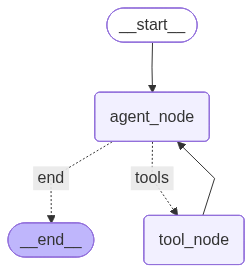

In [54]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [55]:
initial_state = {
    "message": "Give me some vibes",
    "available_tools": tool_descriptions
}
result = graph.invoke(initial_state)

In [56]:
result

{'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'append_vibes', 'args': {'query': 'Generate vibes for me', 'vibe': 'chill and positive'}, 'id': 'call_0', 'type': 'tool_call'}], invalid_tool_calls=[]),
  ToolMessage(content='Generate vibes for me chill and positive', name='append_vibes', tool_call_id='call_0'),
  AIMessage(content='Adding a chill and positive vibe to your query.', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'append_vibes', 'args': {'query': 'Generate vibes for me', 'vibe': 'chill and positive'}, 'id': 'call_0', 'type': 'tool_call'}], invalid_tool_calls=[])],
 'message': 'Give me some vibes',
 'iteration': 2,
 'answer': 'Adding a chill and positive vibe to your query.',
 'available_tools': [{'name': 'append_vibes',
   'description': 'Takes in a query and a vibe and returns a string with the query and the vibe apended',
   'parameters': {'type': 'object',
    'properties': {'query': {'type': 'string